# Fama French Five Factors Replication 
### In this task, we try to replicate the 5 factors in Fama French Five Factor Model
### Model：   Ri−Rf = α +βMkt⋅(RMkt−Rf) + βSMB⋅SMB + βHML⋅HML + βRMW⋅RMW + βCMA⋅CMA + ϵ
(Mkt-Rf): Excess return of the market portfolio (Market return - Risk-free rate).

SMB (Small Minus Big): Return of small-cap stocks minus the return of large-cap stocks.

HML (High Minus Low): Return of stocks with high book-to-market ratio (B/M) minus the return of stocks with low B/M ratio.

RMW (Robust Minus Weak): Return of stocks with strong profitability minus the return of stocks with weak profitability.

CMA (Conservative Minus Aggressive): Return of conservative investments minus the return of aggressive investments.


In [1]:
import pandas as pd
import numpy as np
import wrds
from pandas.tseries.offsets import *
from scipy import stats

In [220]:
###################
# Connect to WRDS #
###################
conn=wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


#### Step0:Data Preparation
In this part, we derive the necessary data for constructing the factors

In [3]:
# Get monthly risk-free rate
rf = conn.get_table(library='ff', table='factors_monthly')[['date', 'rf']]
rf['date'] = pd.to_datetime(rf['date'])
rf['jdate'] = rf['date'] + MonthEnd(0)

In [6]:
rf['rf'] = pd.to_numeric(rf['rf'], errors='coerce')

In [312]:
#Acquire Key Financial Indicators

###################
# Compustat Block #
###################
# comp = conn.raw_sql("""
#                     select gvkey, datadate, at, pstkl, txditc,
#                     pstkrv, seq, pstk,revt, cogs, xsga
#                     from comp.funda
#                     where indfmt='INDL' 
#                     and datafmt='STD'
#                     and popsrc='D'
#                     and consol='C'
#                     and datadate >= '1960-01-01'
#                     """, date_cols=['datadate'])

comp = pd.read_csv("comp_na_daily_all.csv", parse_dates=['datadate'])
comp['year'] = comp['datadate'].dt.year
comp['gvkey'] = comp['gvkey'].astype(str)

In [313]:
# create preferrerd stock
comp['ps'] = np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps'] = np.where(comp['ps'].isnull(), comp['pstk'], comp['ps'])
comp['ps'] = np.where(comp['ps'].isnull(), 0, comp['ps'])
comp['txditc'] = comp['txditc'].fillna(0)
comp['seq'] = comp['seq'].fillna(0)

# create book equity
comp['be'] = comp['seq'] + comp['txditc'] - comp['ps']
comp['be'] = np.where(comp['be'] > 0, comp['be'], np.nan)

# create operating profitability
comp = comp[comp['at'].notna()]
comp[['revt', 'cogs', 'xsga']] = comp[['revt', 'cogs', 'xsga']].fillna(0)
comp['op'] = (comp['revt'] - comp['cogs'] - comp['xsga']) / comp['at']

# create asset growth rate
comp['lat'] = comp.groupby(['gvkey'])['at'].shift(1)
comp['lat'] = np.where(pd.isna(comp['lat']), comp['at'], comp['lat'])
comp['agr'] = (comp['at']-comp['lat']) / comp['lat']

comp = comp.dropna(subset=['be', 'op', 'agr'])
comp.rename(columns={'at': 'total_assets'}, inplace=True)

# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','op','agr', 'total_assets','count']]

In [ ]:
###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
# crsp_m = conn.raw_sql("""
#                       select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
#                       a.ret, a.retx, a.shrout, a.prc
#                       from crsp.msf as a
#                       left join crsp.msenames as b
#                       on a.permno=b.permno
#                       and b.namedt<=a.date
#                       and a.date<=b.nameendt
#                       where a.date between '01/01/1969' and '12/31/2023' 
#                       and b.exchcd between 1 and 3
#                       """, date_cols=['date'])


In [314]:
# Obtain individual stock monthly data
crsp_m = pd.read_csv("crsp_monthly.csv", parse_dates=['date'])
crsp_m.columns = crsp_m.columns.str.lower()
crsp_m[['ret', 'retx']] = crsp_m[['ret', 'retx']].apply(pd.to_numeric, errors='coerce')

In [ ]:
# # Merge crsp_m and crsp_mn on permno
# crsp_mn = pd.read_csv("crsp_a_stock.csv")
# crsp_mn.columns = crsp_mn.columns.str.lower()
# crsp_mn = crsp_mn.drop('date', axis=1)
# crsp_mn['nameendt',] = pd.to_datetime(crsp_mn['nameendt'])
# crsp_mn = crsp_mn.groupby(['permno', 'exchcd', 'shrcd'])['nameendt'].max().reset_index()
# crsp_mn['nameendt',] = pd.to_datetime(crsp_mn['nameendt'])
# crsp_m = pd.merge(crsp_m, crsp_mn, on='permno', how='left')
# 
# # Filter records to match namedt and nameendt date range
# crsp_m = crsp_m[(crsp_m['date'] <= crsp_m['nameendt']) &
#                 (crsp_m['exchcd'].between(1, 3))]

In [315]:
crsp_m = crsp_m[crsp_m['exchcd'].between(1, 3)]

# change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [317]:
# Process Delisting Data

# dlret = conn.raw_sql("""
#                      select permno, dlret, dlstdt 
#                      from crsp.msedelist
#                      """, date_cols=['dlstdt'])

dlret = pd.read_csv('crsp_delist.csv', parse_dates=['DLSTDT'])
dlret.columns = dlret.columns.str.lower()
dlret['dlret'] = pd.to_numeric(dlret['dlret'],errors='coerce')
dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])

crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# retadj factors in the delisting returns 
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp = crsp.dropna(subset=['prc','shrout'])
crsp['me']=crsp['prc'].abs()*crsp['shrout']*1000

crsp=crsp.sort_values(by=['jdate','permco','exchcd','me'])
crsp = crsp.drop_duplicates(subset=['permno', 'jdate'], keep='first')
crsp = crsp[['permno', 'date', 'permco', 'ret', 'retx', 'exchcd', 'shrcd', 'jdate', 'retadj', 'me']]

In [318]:
# Obtain Market Portfolio Return Rate R_Mkt
crsp_mkt = crsp.copy()
crsp_mkt['total_me'] = crsp_mkt.groupby('jdate')['me'].transform('sum')
crsp_mkt['mkt_wgt'] = crsp_mkt['me'] / crsp_mkt['total_me']
crsp_mkt['wgt_ret'] = crsp_mkt['mkt_wgt'] * crsp_mkt['retadj']
market_return = crsp_mkt.groupby('jdate')['wgt_ret'].sum().rename('Rmkt').reset_index()
market_return = market_return.interpolate(method='linear')

count    768.000000
mean       0.015267
std        0.044597
min       -0.211438
25%       -0.011272
50%        0.017278
75%        0.042665
max        0.177375
Name: Rmkt, dtype: float64


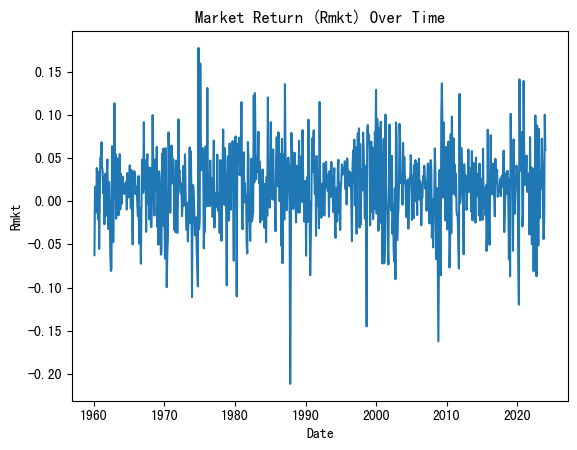

In [320]:
print(market_return['Rmkt'].describe())

import matplotlib.pyplot as plt
plt.plot(market_return['jdate'], market_return['Rmkt'])
plt.title('Market Return (Rmkt) Over Time')
plt.xlabel('Date')
plt.ylabel('Rmkt')
plt.show()


In [321]:
# Aggregate Market Cap
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index() #出现110150缺失值

# join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me'])
crsp1=crsp1.drop(['me'], axis=1)

# join with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

#### Step1: Process Data for the Formation Period (End of June)

In [322]:
# keep December market cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})
decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [323]:
#Last year July to this year June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['retx'] = pd.to_numeric(crsp2['retx'], errors='coerce').fillna(0)
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','jdate'])

In [324]:
# cumret by stock
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# lag cumret
crsp2=crsp2.sort_values(by=['permno','jdate'])
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)

# lag market cap
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])


In [325]:
crsp3['wt']=crsp3['wt'].fillna(0)

In [326]:
# Info as of June
crsp3_jun = crsp3[crsp3['month'] == 6]

crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno', 'year'])
crsp_jun = crsp_jun[
    ['permno', 'date', 'jdate', 'shrcd', 'exchcd', 'retadj', 'me', 'wt', 'cumretx', 'mebase', 'lme', 'dec_me']]
crsp_jun = crsp_jun[crsp_jun['mebase'].notna()]
crsp_jun = crsp_jun.sort_values(by=['permno', 'jdate']).drop_duplicates()

#### Step2: Establish the correspondence between companies and stocks from the Compustat and CRSP databases

In [139]:
#######################
# CCM Block           #
#######################
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

ccm['gvkey'] = ccm['gvkey'].astype(str)

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))
ccm['linkenddt'] = pd.to_datetime(ccm['linkenddt']).dt.date
ccm['permno'] = ccm['permno'].astype(int)

In [345]:
comp['gvkey'] = comp['gvkey'].astype(str).str.zfill(6)
ccm1=pd.merge(comp[['gvkey','datadate','be', 'op','agr','count']],ccm,how='left',on=['gvkey'])
ccm1['yearend'] = ccm1['datadate'] + YearEnd(0)
ccm1['jdate'] = ccm1['yearend'] + MonthEnd(6)
ccm1['linkdt'] = pd.to_datetime(ccm1['linkdt']).fillna(pd.Timestamp('1960-01-01'))
ccm1['linkenddt'] = pd.to_datetime(ccm1['linkenddt']).fillna(pd.Timestamp('2023-12-31'))
ccm1 = ccm1.dropna(subset=['linkdt', 'linkenddt'])

In [346]:
# set link date bounds
ccm2 = ccm1[(ccm1['jdate'] >= ccm1['linkdt']) & (ccm1['jdate'] <= ccm1['linkenddt'])]
ccm2 = ccm2[['gvkey', 'permno', 'datadate', 'yearend', 'jdate', 'be','op','agr', 'count']]

# link comp and crsp
ccm_jun = pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun = ccm_jun.dropna(subset=['be', 'op', 'agr', 'dec_me'])
ccm_jun['beme'] = np.where(ccm_jun['dec_me'] == 0, np.nan, ccm_jun['be'] * 1000 / ccm_jun['dec_me'])

#### Step3: select NYSE stocks for bucket breakdown

In [347]:
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

# size breakdown
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# beme breakdown
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

# operating profitability breakdown
nyse_op=nyse.groupby(['jdate'])['op'].median().to_frame().reset_index().rename(columns={'op':'opmedn'})

# asset growth rate breakdown
nyse_agr=nyse.groupby(['jdate'])['agr'].median().to_frame().reset_index().rename(columns={'agr':'agrmedn'})

nyse_breaks = nyse_sz.merge(nyse_bm, on='jdate').merge(nyse_op, on='jdate').merge(nyse_agr, on='jdate')

# join back all breakdowns for size, beme, operating profitability, and asset growth rate breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])
ccm1_jun = ccm1_jun.dropna(subset=['beme'])

In [349]:
# function to assign sz, bm, op, agr bucket
def sz_bucket(row):
    if pd.isna(row['me']):
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

def op_bucket(row):
    if pd.isna(row['op']):
        value=''
    elif row['op']<=row['opmedn']:
        value='R'
    else:
        value='W'
    return value

def agr_bucket(row):
    if pd.isna(row['agr']):
        value=''
    elif row['agr']<=row['agrmedn']:
        value='C'
    else:
        value='A'
    return value


#### Step4: Portfolio construction

In [350]:
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)

# assign size portfolio (size, book-to-market, operating profitability, investment)
ccm1_jun['szport']=np.where(ccm1_jun['posbm']==1, ccm1_jun.apply(sz_bucket, axis=1), '')
ccm1_jun['bmport']=np.where(ccm1_jun['posbm']==1, ccm1_jun.apply(bm_bucket, axis=1), '')
ccm1_jun['opport']=np.where(ccm1_jun['posbm']==1, ccm1_jun.apply(op_bucket, axis=1), '')
ccm1_jun['agrport']=np.where(ccm1_jun['posbm']==1, ccm1_jun.apply(agr_bucket, axis=1), '')

ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!='')&
                                 (ccm1_jun['szport']!='')&
                                 (ccm1_jun['opport']!='')&
                                 (ccm1_jun['agrport']!=''), 1, 0)

In [351]:
# store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','opport','agrport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3=pd.merge(crsp3,
              june[['permno','ffyear','szport','opport','bmport','agrport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# keeping only records that meet the criteria
ccm4=ccm3[(ccm3['wt']>0)& (ccm3['posbm']==1) & (ccm3['nonmissport']==1) &
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

/var/folders/vt/x4z4r3fd0xg5nszdcjd244900000gn/T/ipykernel_60869/1121668314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear']=june['jdate'].dt.year


#### Step5: Form Fama French Factors

In [335]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [334]:
def calculate_portfolio_returns(data, port_column, ret_col='retadj', weight_col='wt'):
    """
    Calculates value-weighted returns and firm count, returning results in wide format.
    Returns:
    - ff_factors: DataFrame, value-weighted returns in wide format
    - ff_nfirms: DataFrame, firm count in wide format
    """
    
    # Calculate value-weighted returns
    
    vwret = data.groupby(['jdate', port_column]).apply(wavg, ret_col, weight_col).to_frame().reset_index().rename(columns={0: 'vwret'})
    # 
    # vwret = data.groupby(['jdate', port_column], as_index=False, group_keys=False).apply(
    #     wavg, ret_col, weight_col
    # ).reset_index().rename(columns={0: 'vwret'})

    # Calculate firm count
    vwret_n = data.groupby(['jdate', port_column])[ret_col].count().reset_index().rename(columns={ret_col: 'n_firms'})

    # Convert to wide format
    ff_factors = vwret.pivot(index='jdate', columns=port_column, values='vwret').reset_index()
    ff_nfirms = vwret_n.pivot(index='jdate', columns=port_column, values='n_firms').reset_index()

    return ff_factors, ff_nfirms

In [352]:
#Portfolio Label
ccm4.loc[:, 'sbport'] = ccm4['szport'] + ccm4['bmport']
ccm4.loc[:, 'sopport'] = ccm4['szport'] + ccm4['opport']
ccm4.loc[:, 'sagrport'] = ccm4['szport'] + ccm4['agrport']

# Size and Book-to-Market portfolio
ff_factors_sb, ff_nfirms_sb = calculate_portfolio_returns(ccm4, 'sbport')

# Size and Operating Profitability portfolio
ff_factors_sop, ff_nfirms_sop = calculate_portfolio_returns(ccm4, 'sopport')

# Size and Investment portfolio
ff_factors_sagr, ff_nfirms_sagr = calculate_portfolio_returns(ccm4, 'sagrport')

# Concatenate the factors on 'date'
ff_factors = pd.concat([ff_factors_sb.set_index('jdate'),
                        ff_factors_sop.set_index('jdate'),
                        ff_factors_sagr.set_index('jdate')],
                       axis=1).reset_index()

#Concatenate the firm counts on 'date'
ff_nfirms = pd.concat([ff_nfirms_sb.set_index('jdate'),
                       ff_nfirms_sop.set_index('jdate'),
                       ff_nfirms_sagr.set_index('jdate')],
                      axis=1).reset_index()

/var/folders/vt/x4z4r3fd0xg5nszdcjd244900000gn/T/ipykernel_60869/770800301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccm4.loc[:, 'sbport'] = ccm4['szport'] + ccm4['bmport']
/var/folders/vt/x4z4r3fd0xg5nszdcjd244900000gn/T/ipykernel_60869/770800301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccm4.loc[:, 'sopport'] = ccm4['szport'] + ccm4['opport']
/var/folders/vt/x4z4r3fd0xg5nszdcjd244900000gn/T/ipykernel_60869/770800301.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [337]:
def calculate_five_factors(ff_factors, ff_nfirms):
    """
    Calculates the Fama-French 5 factors (SMB, HML, RMW, CMA) and firm counts.

    Parameters:
    - ff_factors: DataFrame, value-weighted returns for different portfolios
    - ff_nfirms: DataFrame, firm counts for different portfolios
    
    Returns:
    - ff_factors: DataFrame, updated with SMB, HML, RMW, and CMA factors
    - ff_nfirms: DataFrame, updated with firm counts for each factor
    """

    # SMB and HML calculation
    ff_factors['WH'] = (ff_factors['BH'] + ff_factors['SH']) / 2
    ff_factors['WL'] = (ff_factors['BL'] + ff_factors['SL']) / 2
    ff_factors['WHML'] = ff_factors['WH'] - ff_factors['WL']

    ff_factors['WB'] = (ff_factors['BL'] + ff_factors['BM'] + ff_factors['BH']) / 3
    ff_factors['WS'] = (ff_factors['SL'] + ff_factors['SM'] + ff_factors['SH']) / 3
    ff_factors['WSMB'] = ff_factors['WS'] - ff_factors['WB']

    # RMW calculation
    ff_factors['WR'] = (ff_factors['BR'] + ff_factors['SR']) / 2
    ff_factors['WW'] = (ff_factors['BW'] + ff_factors['SW']) / 2
    ff_factors['WRMW'] = ff_factors['WR'] - ff_factors['WW']

    # CMA calculation
    ff_factors['WC'] = (ff_factors['BC'] + ff_factors['SC']) / 2
    ff_factors['WA'] = (ff_factors['BA'] + ff_factors['SA']) / 2
    ff_factors['WCMA'] = ff_factors['WC'] - ff_factors['WA']

    # Rename date column for consistency
    ff_factors = ff_factors.rename(columns={'jdate': 'date'})

    # Firm counts for HML and SMB
    ff_nfirms['H'] = ff_nfirms['SH'] + ff_nfirms['BH']
    ff_nfirms['L'] = ff_nfirms['SL'] + ff_nfirms['BL']
    ff_nfirms['HML'] = ff_nfirms['H'] + ff_nfirms['L']

    ff_nfirms['B'] = ff_nfirms['BL'] + ff_nfirms['BM'] + ff_nfirms['BH']
    ff_nfirms['S'] = ff_nfirms['SL'] + ff_nfirms['SM'] + ff_nfirms['SH']
    ff_nfirms['SMB'] = ff_nfirms['B'] + ff_nfirms['S']
    ff_nfirms['TOTAL'] = ff_nfirms['SMB']

    # Firm counts for RMW
    ff_nfirms['R'] = ff_nfirms['SR'] + ff_nfirms['BR']
    ff_nfirms['W'] = ff_nfirms['SW'] + ff_nfirms['BW']
    ff_nfirms['RMW'] = ff_nfirms['R'] + ff_nfirms['W']

    # Firm counts for CMA
    ff_nfirms['C'] = ff_nfirms['SC'] + ff_nfirms['BC']
    ff_nfirms['A'] = ff_nfirms['SA'] + ff_nfirms['BA']
    ff_nfirms['CMA'] = ff_nfirms['C'] + ff_nfirms['A']

    ff_nfirms = ff_nfirms.rename(columns={'jdate': 'date'})

    return ff_factors, ff_nfirms


In [353]:
# Calculating all factors
ff_factors_all, ff_nfirms_all = calculate_five_factors(ff_factors, ff_nfirms)

In [354]:
# Derive Market Excess Return
rf=rf[['jdate','rf']]
Market = pd.merge(market_return,rf,how = 'left',on='jdate')
Market['Mkt-Rf']=Market ['Rmkt'] - Market ['rf']  # Assuming 'rf' is already available
Market.rename(columns={'jdate':'date'}, inplace=True)

# Add Mkt-Rf to ff_factors_all
ff_factors_all = pd.merge(ff_factors_all,Market[['date','Mkt-Rf']],how = 'left',on='date')

In [355]:
ff_factors_all

,date,BH,BL,BM,SH,SL,SM,BR,BW,SR,...,WB,WS,WSMB,WR,WW,WRMW,WC,WA,WCMA,Mkt-Rf
0,1962-07-31,0.081179,0.084395,0.026085,0.018969,0.102221,0.042604,0.059438,0.077394,0.052866,...,0.063886,0.054598,-0.009289,0.056152,0.065469,-0.009317,0.059759,0.062569,-0.002810,0.060966
1,1962-08-31,0.022977,-0.009311,0.017976,0.057387,0.022036,0.030780,0.022168,-0.006645,0.036808,...,0.010547,0.036734,0.026187,0.029488,0.012604,0.016884,0.020048,0.019271,0.000777,0.023515
2,1962-09-30,-0.018181,-0.078618,-0.033099,-0.061105,-0.046942,-0.078386,-0.045273,-0.055063,-0.073416,...,-0.043299,-0.062144,-0.018845,-0.059344,-0.055420,-0.003924,-0.053344,-0.063012,0.009667,-0.049444
3,1962-10-31,-0.003807,0.005653,0.020265,-0.029558,-0.035068,0.005295,0.005411,0.007123,-0.004398,...,0.007371,-0.019777,-0.027147,0.000507,-0.009826,0.010333,-0.004949,-0.002560,-0.002389,0.002306
4,1962-11-30,0.086281,0.141832,0.133589,0.161961,0.095632,0.145565,0.108280,0.136185,0.153146,...,0.120567,0.134386,0.013819,0.130713,0.125196,0.005517,0.119946,0.139315,-0.019370,0.111273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,2023-08-31,-0.035636,-0.011245,-0.032978,-0.056878,-0.067589,-0.059455,-0.036507,-0.010984,-0.080638,...,-0.026619,-0.061307,-0.034688,-0.058573,-0.019901,-0.038671,-0.044441,-0.035405,-0.009036,-0.019829
734,2023-09-30,-0.032649,-0.055054,-0.026740,-0.061087,-0.062999,-0.060944,-0.045853,-0.046598,-0.073913,...,-0.038147,-0.061677,-0.023529,-0.059883,-0.044448,-0.015435,-0.058816,-0.049679,-0.009138,-0.048104
735,2023-10-31,-0.030034,-0.015795,-0.041364,-0.068786,-0.091913,-0.058994,-0.022556,-0.023551,-0.081175,...,-0.029064,-0.073231,-0.044166,-0.051866,-0.039337,-0.012528,-0.047178,-0.047005,-0.000173,-0.028398
736,2023-11-30,0.099567,0.097550,0.078545,0.100148,0.094044,0.091210,0.110940,0.085835,0.108792,...,0.091888,0.095134,0.003246,0.109866,0.079664,0.030202,0.092789,0.094171,-0.001382,0.095671


In [356]:
ff_nfirms_all

,date,BH,BL,BM,SH,SL,SM,BR,BW,SR,...,B,S,SMB,TOTAL,R,W,RMW,C,A,CMA
0,1962-07-31,14,18,13,13,10,23,21,24,25,...,45,46,91,91,46,45,91,46,45,91
1,1962-08-31,14,18,13,13,10,23,21,24,25,...,45,46,91,91,46,45,91,46,45,91
2,1962-09-30,14,18,13,13,10,23,21,24,25,...,45,46,91,91,46,45,91,46,45,91
3,1962-10-31,14,18,13,13,10,23,21,24,25,...,45,46,91,91,46,45,91,46,45,91
4,1962-11-30,14,18,13,13,10,23,21,24,25,...,45,46,91,91,46,45,91,46,45,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,2023-08-31,132,429,332,1157,490,866,377,516,1947,...,893,2513,3406,3406,2324,1082,3406,1819,1587,3406
734,2023-09-30,131,428,332,1149,490,859,376,515,1934,...,891,2498,3389,3389,2310,1079,3389,1806,1583,3389
735,2023-10-31,131,426,332,1142,487,850,375,514,1918,...,889,2479,3368,3368,2293,1075,3368,1793,1575,3368
736,2023-11-30,131,425,331,1133,486,843,374,513,1904,...,887,2462,3349,3349,2278,1071,3349,1780,1569,3349


#### Step6： Compare with FF

In [361]:
# _ff = conn.get_table(library='ff', table='factors_monthly')
_ff = pd.read_csv('F-F_Research_Data_5_Factors_2x3 2.csv')
_ff['date'] = pd.to_datetime(_ff['date'].astype(str), format='%Y%m') + MonthEnd(0)
_ff=_ff[['date','mkt-rf','smb','hml','rmw','cma']]


_ffcomp = pd.merge(_ff, ff_factors_all[['date','Mkt-Rf','WSMB','WHML','WRMW','WCMA']], how='inner', on=['date'])
_ffcomp.date = pd.to_datetime(_ffcomp.date)
_ffcomp.set_index('date', inplace=True)

_ffcomp70=_ffcomp[_ffcomp.index>='1970-01-01']

Market Excess Return correlation: PearsonRResult(statistic=0.9922619845474661, pvalue=0.0)
SMB correlation: PearsonRResult(statistic=0.9803196894135767, pvalue=0.0)
HML correlation: PearsonRResult(statistic=0.9816752365403687, pvalue=0.0)
RMW correlation: PearsonRResult(statistic=-0.6475488028209391, pvalue=2.730239781901815e-78)
CMA correlation: PearsonRResult(statistic=0.9400668321037344, pvalue=4.728425727236588e-304)


In [362]:
# Define time periods
time_periods = {
    'whole_sample': ('1969-01-01', '2023-12-31'),
    'pre_1993': ('1969-01-01', '1993-01-01'),
    '1993_2003': ('1993-01-01', '2003-12-31'),
    '2003_2023': ('2003-01-01', '2023-12-31')
}

# Lists to store the data for each period
result_diff = []
result_corr = []

# Loop to calculate mean(abs(diff)) and correlation for each period
for period, (start_date, end_date) in time_periods.items():
    # Filter data for the current time period
    df_period = _ffcomp70[(start_date <= _ffcomp70.index) & (_ffcomp70.index <= end_date)]

    # Calculate mean(abs(diff)) for each factor
    diff_mean = {
        'time_period': period,
        'Mkt-Rf_mean_diff': np.mean(np.abs(df_period['mkt-rf'] - df_period['Mkt-Rf'])),
        'SMB_mean_diff': np.mean(np.abs(df_period['smb'] - df_period['WSMB'])),
        'HML_mean_diff': np.mean(np.abs(df_period['hml'] - df_period['WHML'])),
        'RMW_mean_diff': np.mean(np.abs(df_period['rmw'] - df_period['WRMW'])),
        'CMA_mean_diff': np.mean(np.abs(df_period['cma'] - df_period['WCMA']))
    }
    result_diff.append(diff_mean)

    # Calculate correlation for each factor
    corr_mean = {
        'time_period': period,
        'Mkt-Rf_corr': stats.pearsonr(df_period['mkt-rf'], df_period['Mkt-Rf'])[0],
        'SMB_corr': stats.pearsonr(df_period['smb'], df_period['WSMB'])[0],
        'HML_corr': stats.pearsonr(df_period['hml'], df_period['WHML'])[0],
        'RMW_corr': stats.pearsonr(df_period['rmw'], df_period['WRMW'])[0],
        'CMA_corr': stats.pearsonr(df_period['cma'], df_period['WCMA'])[0]
    }
    result_corr.append(corr_mean)

# Convert lists to DataFrames
df_diff = pd.DataFrame(result_diff)
df_corr = pd.DataFrame(result_corr)

# Merge mean absolute difference and correlation results
result_summary = pd.merge(df_diff, df_corr, on='time_period')

# Save the result to Excel
result_summary.to_excel('factor_comparison_summary.xlsx', index=False, sheet_name='Factor Comparison')

print("Results saved to 'factor_comparison_summary.xlsx'")

Results saved to 'factor_comparison_summary.xlsx'


In [ ]:
result_df.to_excel('factor_differences_report.xlsx', sheet_name='Factor Differences')